# Tutorial 8. Machine Learning - Python Version
Athena Liu

March 26, 2020

In [18]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1: Frame the Problem
See LiveScript.

## Step 2: Get the Data

In [3]:
data = pd.read_csv("Car_Advertisement.csv");
m = len(data) # 400

### Train-Test Split 

In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)
train_data.head()

,UserID,Gender,Age,EstimatedSalary,Purchased
100,15766289,Male,27,88000,Not Purchased
101,15593014,Male,28,59000,Not Purchased
194,15689751,Male,28,89000,Not Purchased
173,15581654,Female,34,43000,Not Purchased
358,15573926,Male,40,71000,Purchased


## Step 3: Explore the Training Data

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 100 to 62
Data columns (total 5 columns):
UserID             320 non-null int64
Gender             320 non-null object
Age                320 non-null int64
EstimatedSalary    320 non-null int64
Purchased          320 non-null object
dtypes: int64(3), object(2)
memory usage: 15.0+ KB


Summary of each numerical attribute:

In [13]:
train_data.describe()

,UserID,Age,EstimatedSalary
count,3.200000e+02,320.000000,320.000000
mean,1.569258e+07,37.925000,70053.125000
std,7.097693e+04,10.275545,33746.152544
min,1.556669e+07,18.000000,15000.000000
25%,1.563077e+07,30.000000,44750.000000
50%,1.569722e+07,37.000000,69500.000000
75%,1.574955e+07,46.000000,88000.000000
max,1.581524e+07,60.000000,150000.000000


Value counts of categorical attributes:

In [15]:
train_data["Gender"].value_counts()

Female    164
Male      156
Name: Gender, dtype: int64

In [16]:
train_data["Purchased"].value_counts()

Not Purchased    206
Purchased        114
Name: Purchased, dtype: int64

In [39]:
Y_train = train_data["Purchased"].copy()
X_train = train_data.drop(["Purchased", "UserID"], axis=1) 
m_train = len(X_train)
X_train.head()

,Gender,Age,EstimatedSalary
100,Male,27,88000
101,Male,28,59000
194,Male,28,89000
173,Female,34,43000
358,Male,40,71000


In [40]:
Y_train.head()

100    Not Purchased
101    Not Purchased
194    Not Purchased
173    Not Purchased
358        Purchased
Name: Purchased, dtype: object

### Visualize the data 

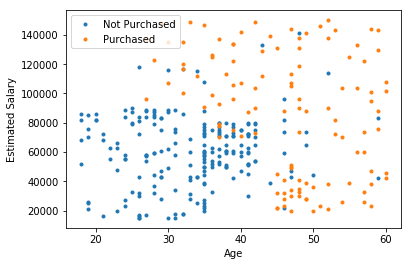

In [94]:
def plot_scatter_with_labels(X1, X2, Y, xlabel="Age", ylabel="Estimated Salary"): 
    df = pd.DataFrame(dict(x1=X1, x2=X2, label=Y))
    groups = df.groupby("label")
    for name, group in groups:
        plt.plot(group.x1, group.x2, 
                 marker="o", linestyle="", ms=3,
                 label=name)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plot_scatter_with_labels(train_data["Age"],
                         train_data["EstimatedSalary"], 
                         train_data["Purchased"])

## Step 4: Pre-processing the Data
### Handling Categorical Features
We can convert category text to numbers using sklearn's OrdinalEncoder class:

In [41]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
Gender_encoded = ordinal_encoder.fit_transform(X_train[["Gender"]])
Gender_encoded[:5]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [42]:
ordinal_encoder.categories_

[array(['Female', 'Male'], dtype=object)]

The encoder automatically set Female = 0, Male = 1

### Feature Scaling 

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[["Age", "EstimatedSalary"]])

X_train[:3, :]

/Users/athena/Desktop/ML/handson-ml/my_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/athena/Desktop/ML/handson-ml/my_env/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-1.06486906,  0.53265281],
       [-0.96739821, -0.32805032],
       [-0.96739821,  0.56233223]])

### Feature Selection
As I have explained in the MATLAB LiveScript, we decide not to include "Gender" as input features.

## Step 5: Try out Different ML Models
### Model 1: Discriminant Analysis Classifier


In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
da_clf = LinearDiscriminantAnalysis()
da_clf.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

### Evaluate Using Cross-Validation 

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(da_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
scores

array([0.87878788, 0.81818182, 0.84848485, 0.72727273, 0.8125    ,
       0.78125   , 0.90322581, 0.90322581, 0.83870968, 0.83870968])

In [64]:
np.average(scores) # averaged cv scores of 10 cross validations

0.8350348240469208

Let's create a dictionary to save the average cv scores of different classifiers so that we can compare later:

In [65]:
avg_cv_scores = {} # dictionary to store all avg scores
avg_cv_scores["DA"] = np.average(scores)

### Visualization: Decision Boundary

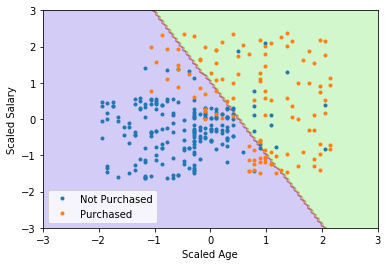

In [170]:
def plot_decision_boundary(clf, axes, inverse=False):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_pred = y_pred =="Purchased"
    if inverse:
        X = scaler.inverse_transform(np.c_[x0s, x1s])
        x0, x1 = np.meshgrid(X[:,0], X[:,1])
        
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

def plot_prediction_results(clf, X, Y):
    plot_decision_boundary(clf, [-3, 3, -3, 3])
    plot_scatter_with_labels(X[:,0], X[:,1], Y, 
                             xlabel="Scaled Age", ylabel="Scaled Salary")

plot_prediction_results(da_clf, X_train, Y_train)

### Model 2: Naive Bayes Classifier 

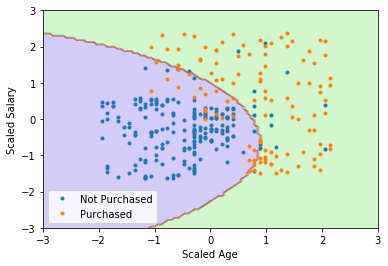

In [97]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train, Y_train)
scores = cross_val_score(nb_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
avg_cv_scores["NB"] = np.average(scores)
plot_prediction_results(nb_clf, X_train, Y_train)

### Model 3: KNN
`n_neighbors` is a hyperparameter that you can tune to get a best result.

Lower n_neighbors = more DOF = more likely to overfit

0.8910251710654936


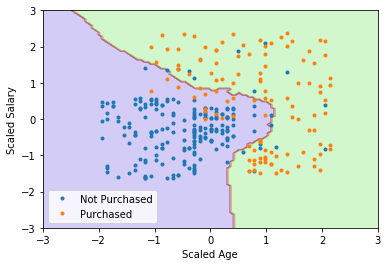

In [104]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=30) # change n_neighbors, see what happens!
knn_clf.fit(X_train, Y_train)
scores = cross_val_score(knn_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
avg_cv_scores["KNN"] = np.average(scores)
print(avg_cv_scores["KNN"] )
plot_prediction_results(knn_clf, X_train, Y_train)

### Model 4: SVM-Linear 

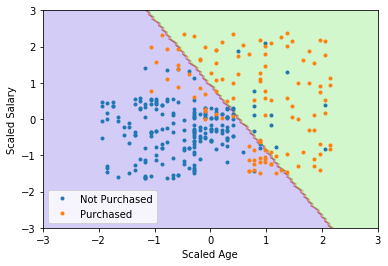

In [98]:
from sklearn.svm import SVC
svmln_clf = SVC(kernel="linear", C=1)
svmln_clf.fit(X_train, Y_train)
scores = cross_val_score(svmln_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
avg_cv_scores["SVM-linear"] = np.average(scores)
plot_prediction_results(svmln_clf, X_train, Y_train)

### Model 5: SVM-Non-linear 

0.8381476050830889


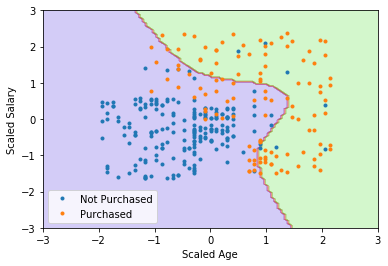

In [143]:
svmpoly_clf = SVC(kernel="poly", gamma='auto') # Play with degree and C
svmpoly_clf.fit(X_train, Y_train)
scores = cross_val_score(svmpoly_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
avg_cv_scores["SVM-poly"] = np.average(scores)
print(avg_cv_scores["SVM-poly"] )
plot_prediction_results(svmpoly_clf, X_train, Y_train)

0.9127229960899316


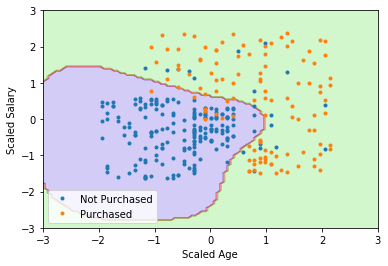

In [146]:
#Gaussian Radial Basis Function (RBF) Kernel
svmgauss_clf = SVC(kernel="rbf", gamma=1, C=1) # Play with hyperparameters
svmgauss_clf.fit(X_train, Y_train)
scores = cross_val_score(svmgauss_clf, X_train, Y_train,
                        scoring="accuracy", cv=10)
avg_cv_scores["SVM-gauss"] = np.average(scores)
print(avg_cv_scores["SVM-gauss"] )
plot_prediction_results(svmgauss_clf, X_train, Y_train)

## Step 6: Fine-Tune the System
Topics we don't have time to cover in this tutorial:
### Tuning Hyperparameters using Grid Search
### Using Ensemble Models

We will do these only:
### Choose Final Model

In [147]:
avg_cv_scores

{'DA': 0.8350348240469208,
 'NB': 0.8756781524926686,
 'SVM-linear': 0.8354258308895405,
 'KNN': 0.8910251710654936,
 'SVM-poly': 0.8381476050830889,
 'SVM-gauss': 0.9127229960899316}

For the same reasoning as I presented in the MATLAB LiveScript, I am going to go with SVM-Gaussian kernel.

### Check Performace on Test Set

In [157]:
# Note you need to use "transform" not "fit_transform"
X_test = scaler.transform(test_data[["Age", "EstimatedSalary"]])
Y_test_pred = svmgauss_clf.predict(X_test)
accuracy = np.sum(Y_test_pred==test_data["Purchased"])/len(Y_test_pred)
print("Accuracy on test set: ",accuracy)

Accuracy on test set:  0.9375


/Users/athena/Desktop/ML/handson-ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


## Step 7: Present Your Solution & Launch

[15, 65, 0, 160000]

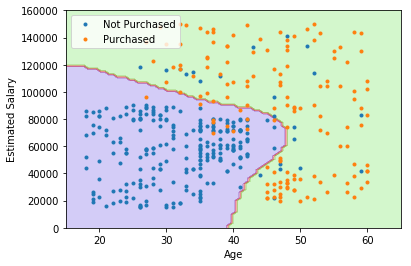

In [176]:
plot_scatter_with_labels(data["Age"],
                         data["EstimatedSalary"], 
                         data["Purchased"])
plot_decision_boundary(svmgauss_clf, [-3, 3, -3, 3], inverse=True)
plt.axis([15, 65, 0, 160000])

And report that our classifier can predict 94% of the customers if they will purchase or not correctly based on their salary and age.
Also we can report that Gender is not a critical factor in the prediction and the company does not need to collect that information in the future.

# More Learning Resources

If you want to learn more about practical machine learning in Python, you should checkout Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurélien Géron: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ . 

Be sure to work through Chapter 2, where you will work through an end-to-end ML project on a Regression problem. Actually, I based my tutorial on this chapter! You will defintely learn more by reading the book.

UBC students can read the online version for free. The author also uploaded all his Notebooks to Github, open source for everyone to download and learn.